# Image cropping function in action
## load data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from spatial_tools.image.manipulate import crop_img
from spatial_tools.image.tools import read_tif

import skimage.feature as sk_image

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)

#### get feature abt

In [85]:
def get_features_abt(image, spot_ids, xcoord, ycoord, spot_diameter, features=["hog"]):
    """
    image: array of whole image to crop and calc features from
    spot_ids: array of integers of the spot_id to analyze
    xccord, ycoord: array of ints
    spot_diameter: float
    features: list of feature names to add to dataframe, default to hog
    """
    features_log = pd.DataFrame()
    
    for spot_id in spot_ids:
        crop_ = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, 
                          sizef=1, spot_diameter=spot_diameter)
        
        features_pd = get_features_statistics(crop_, spot_id, features=features)
        
        features_log = pd.concat([features_log, features_pd], axis=0)
        
    features_log.set_index(["spot_id"], inplace=True)
    return features_log

def get_features_statistics(im, spot_id, features=["hog"]):
    """
    im: image (numpy array)
    spot_id: the spot id of the image element, int
    features: features to calculate (str), List
    output: pandas Data frame with all features for a image or crop
    """
    features_pd = pd.DataFrame([spot_id], columns=["spot_id"])
    
    for feature in features:
        if feature == "hog":
            features_pd = pd.concat([features_pd, get_hog_features(im)], axis=1)
    return features_pd

def get_hog_features(im):
    """
    im: image or image crop, numpy array
    spot_id: the spot id of the image element, int
    output: numpy array with hog features
    """
    features = sk_image.hog(im)
    hog_pd = pd.DataFrame(features).T
    hog_pd.columns = [str(col) + '_hog' for col in hog_pd.columns]
    return hog_pd

In [86]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

img = read_tif(dataset_folder, dataset_name)

xcoord = adata.obsm["spatial"][:, 0]
ycoord = adata.obsm["spatial"][:, 1]
spot_diameter = adata.uns['spatial'][dataset_name]['scalefactors']['spot_diameter_fullres']

spot_ids = np.arange(0,10,1)


features_log = get_features_abt(img, spot_ids, xcoord, ycoord, spot_diameter, features=["hog"])
features_log

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/olle.holmberg/anaconda3/envs/hackathon-spatial/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,0_hog,1_hog,2_hog,3_hog,4_hog,5_hog,6_hog,7_hog,8_hog,9_hog,...,6551_hog,6552_hog,6553_hog,6554_hog,6555_hog,6556_hog,6557_hog,6558_hog,6559_hog,6560_hog
spot_id,,,,,,,,,,,,,,,,,,,,,
0,0.142508,0.055804,0.010893,0.038074,0.103839,0.100785,0.022411,0.099197,0.153254,0.076143,...,0.095315,0.057765,0.080614,0.088819,0.110276,0.180160,0.023452,0.025443,0.099020,0.158989
1,0.196273,0.180013,0.153482,0.031666,0.115323,0.049121,0.052532,0.033917,0.049992,0.074650,...,0.014221,0.032638,0.091746,0.101810,0.159569,0.075604,0.047895,0.043252,0.137404,0.087086
2,0.085761,0.040085,0.015754,0.078683,0.145507,0.090550,0.040465,0.033820,0.022875,0.213458,...,0.143056,0.050090,0.071639,0.030761,0.048948,0.045721,0.099824,0.053304,0.048784,0.099000
3,0.086159,0.023431,0.119787,0.073737,0.210138,0.060925,0.034919,0.060748,0.024580,0.099000,...,0.066143,0.133242,0.056834,0.135558,0.042881,0.124421,0.080901,0.050433,0.038195,0.077384
4,0.212877,0.072862,0.084954,0.113582,0.173368,0.032719,0.045506,0.026452,0.051656,0.098131,...,0.182120,0.053097,0.079310,0.066039,0.104964,0.170851,0.145713,0.123987,0.137607,0.110540
5,0.150738,0.215759,0.149532,0.100038,0.187134,0.023664,0.086682,0.074917,0.038891,0.116227,...,0.022424,0.055747,0.138783,0.214529,0.214387,0.104515,0.066390,0.033461,0.015850,0.032403
6,0.174012,0.058884,0.066128,0.021685,0.095461,0.079950,0.104693,0.050519,0.019576,0.222078,...,0.066376,0.167479,0.141959,0.038596,0.044499,0.055063,0.027561,0.076874,0.057094,0.165832
7,0.140165,0.042695,0.023924,0.045290,0.216118,0.216118,0.216118,0.095493,0.027842,0.123821,...,0.028492,0.044997,0.057866,0.069732,0.130339,0.038880,0.096392,0.048898,0.074208,0.030153
8,0.210230,0.210230,0.210230,0.095114,0.158538,0.030380,0.020032,0.024770,0.045952,0.146233,...,0.038038,0.029349,0.044280,0.107941,0.042283,0.123921,0.088031,0.124785,0.137864,0.107012


In [88]:
xcoord

array([8230, 4170, 2519, ..., 3276, 3069, 4720])

In [87]:
spot_diameter

89.44476048022638

## crop image
- use different sizefactors and scalefactors
- try masking

location of the spot that we are cropping

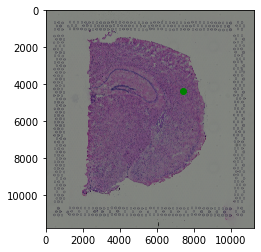

In [6]:
spot_id = 100
plt.scatter(xcoord[spot_id], ycoord[spot_id], c='green')
plt.imshow(img)

crop with different neighborhood sizes. Note that the function also works when the range is outside the image

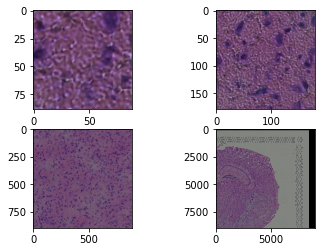

In [7]:
crop_1 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, sizef=1, spot_diameter=spot_diameter)
crop_2 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, sizef=2, spot_diameter=spot_diameter)
crop_10 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, sizef=10, spot_diameter=spot_diameter)
crop_100 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, sizef=100, spot_diameter=spot_diameter)

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(crop_1)
axes[0][1].imshow(crop_2)
axes[1][0].imshow(crop_10)
axes[1][1].imshow(crop_100)

In [ ]:
img.shape

crop with different scales - note how the crops get smaller with smaller `scalef`

In [ ]:
crop_1 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=1, sizef=10, spot_diameter=spot_diameter)
crop_05 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=0.5, sizef=10, spot_diameter=spot_diameter)
crop_025 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=0.25, sizef=10, spot_diameter=spot_diameter)
crop_01 = crop_img(img, xcoord[spot_id], ycoord[spot_id], scalef=0.1, sizef=10, spot_diameter=spot_diameter)

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(crop_1)
axes[0][1].imshow(crop_05)
axes[1][0].imshow(crop_025)
axes[1][1].imshow(crop_01)